# 介绍

PieChart是Google官方教程中一个完整讲解自定义控件的例子，[教程链接英文](http://android-doc.github.io/training/custom-views/create-view.html)，这个例子几乎包含了自定义View的所有场景，非常优秀的教程，下面展示效果图：

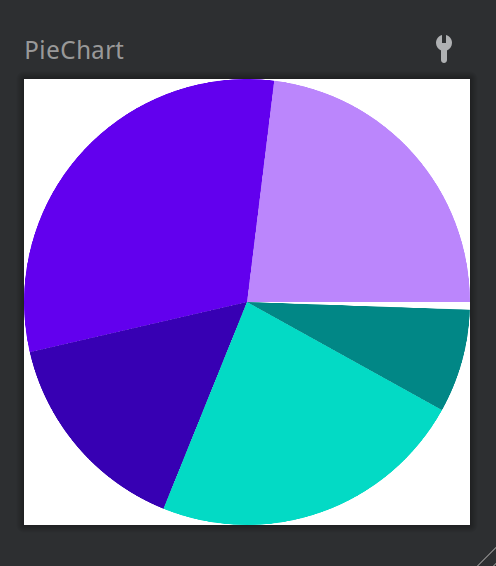

```java
    public PieChart(Context context) {
        super(context);
        init();
    }

    public PieChart(Context context, AttributeSet attrs) {
        super(context, attrs);

        TypedArray a = context.getTheme().obtainStyledAttributes(
                attrs,
                R.styleable.PieChart,
                0, 0
        );

        try {
            mShowText = a.getBoolean(R.styleable.PieChart_showText, false);
            mTextY = a.getDimension(R.styleable.PieChart_labelY, 0.0f);
            mTextWidth = a.getDimension(R.styleable.PieChart_labelWidth, 0.0f);
            mTextHeight = a.getDimension(R.styleable.PieChart_labelHeight, 0.0f);
            mTextPos = a.getInteger(R.styleable.PieChart_labelPosition, 0);
            mTextColor = a.getColor(R.styleable.PieChart_labelColor, 0xff000000);
            mHighlightStrength = a.getFloat(R.styleable.PieChart_highlightStrength, 1.0f);
            mPieRotation = a.getInt(R.styleable.PieChart_pieRotation, 0);
            mPointerRadius = a.getDimension(R.styleable.PieChart_pointerRadius, 2.0f);
            mAutoCenterInSlice = a.getBoolean(R.styleable.PieChart_autoCenterPointerInSlice, false);
        } finally {
            a.recycle();
        }

        init();
    }
```
重载了两个关键的构造方法，使用时直接new PieChart(context)调用第一个，xml使用时则调用第二个，TypedArray获取属性设置后try finally保证实例回收，初始化方法init在这之后调用。

```java
    public void setShowText(boolean showText) {
        mShowText = showText;
        invalidate();
    }
```
对外开放设置关键属性的方法，立即调用invalidate方法重绘使设置数据马上刷新。

# isInEditMode

isInEditMode 方法在AndroidStudio开发预览中返回true，很不错的调试小技巧

```java
        // In edit mode it's nice to have some demo data, so add that here.
        if (this.isInEditMode()) {
            Resources res = getResources();
            addItem("Annabelle", 3, res.getColor(R.color.purple_200));
            addItem("Brunhilde", 4, res.getColor(R.color.purple_500));
            addItem("Carolina", 2, res.getColor(R.color.purple_700));
            addItem("Dahlia", 3, res.getColor(R.color.teal_200));
            addItem("Ekaterina", 1, res.getColor(R.color.teal_700));
        }
```

# 附上完整源码

```java
package com.example.piechart;
/* Copyright (C) 2012 The Android Open Source Project
    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.
*/

import android.animation.Animator;
import android.animation.ObjectAnimator;
import android.animation.ValueAnimator;
import android.content.Context;
import android.content.res.Resources;
import android.content.res.TypedArray;
import android.graphics.*;
import android.os.Build;
import android.util.AttributeSet;
import android.view.*;
import android.widget.Scroller;


import java.lang.Math;
import java.lang.Override;
import java.lang.String;
import java.util.ArrayList;
import java.util.List;

/**
 * Custom view that shows a pie chart and, optionally, a label.
 */
public class PieChart extends ViewGroup {
    private List<Item> mData = new ArrayList<Item>();

    private float mTotal = 0.0f;

    private RectF mPieBounds = new RectF();

    private Paint mPiePaint;
    private Paint mTextPaint;
    private Paint mShadowPaint;

    private boolean mShowText = false;

    private float mTextX = 0.0f;
    private float mTextY = 0.0f;
    private float mTextWidth = 0.0f;
    private float mTextHeight = 0.0f;
    private int mTextPos = TEXTPOS_LEFT;

    private float mHighlightStrength = 1.15f;

    private float mPointerRadius = 2.0f;
    private float mPointerX;
    private float mPointerY;

    private int mPieRotation;

    private OnCurrentItemChangedListener mCurrentItemChangedListener = null;

    private int mTextColor;
    private PieView mPieView;
    private Scroller mScroller;
    private ValueAnimator mScrollAnimator;
    private GestureDetector mDetector;
    private PointerView mPointerView;

    // The angle at which we measure the current item. This is
    // where the pointer points.
    private int mCurrentItemAngle;

    // the index of the current item.
    private int mCurrentItem = 0;
    private boolean mAutoCenterInSlice;
    private ObjectAnimator mAutoCenterAnimator;
    private RectF mShadowBounds = new RectF();

    /**
     * Draw text to the left of the pie chart
     */
    public static final int TEXTPOS_LEFT = 0;

    /**
     * Draw text to the right of the pie chart
     */
    public static final int TEXTPOS_RIGHT = 1;

    /**
     * The initial fling velocity is divided by this amount.
     */
    public static final int FLING_VELOCITY_DOWNSCALE = 4;

    /**
     *
     */
    public static final int AUTOCENTER_ANIM_DURATION = 250;

    /**
     * Interface definition for a callback to be invoked when the current
     * item changes.
     */
    public interface OnCurrentItemChangedListener {
        void OnCurrentItemChanged(PieChart source, int currentItem);
    }

    /**
     * Class constructor taking only a context. Use this constructor to create
     * {@link PieChart} objects from your own code.
     *
     * @param context
     */
    public PieChart(Context context) {
        super(context);
        init();
    }

    /**
     * Class constructor taking a context and an attribute set. This constructor
     * is used by the layout engine to construct a {@link PieChart} from a set of
     * XML attributes.
     *
     */
    public PieChart(Context context, AttributeSet attrs) {
        super(context, attrs);

        // attrs contains the raw values for the XML attributes
        // that were specified in the layout, which don't include
        // attributes set by styles or themes, and which may have
        // unresolved references. Call obtainStyledAttributes()
        // to get the final values for each attribute.
        //
        // This call uses R.styleable.PieChart, which is an array of
        // the custom attributes that were declared in attrs.xml.
        TypedArray a = context.getTheme().obtainStyledAttributes(
                attrs,
                R.styleable.PieChart,
                0, 0
        );

        try {
            // Retrieve the values from the TypedArray and store into
            // fields of this class.
            //
            // The R.styleable.PieChart_* constants represent the index for
            // each custom attribute in the R.styleable.PieChart array.
            mShowText = a.getBoolean(R.styleable.PieChart_showText, false);
            mTextY = a.getDimension(R.styleable.PieChart_labelY, 0.0f);
            mTextWidth = a.getDimension(R.styleable.PieChart_labelWidth, 0.0f);
            mTextHeight = a.getDimension(R.styleable.PieChart_labelHeight, 0.0f);
            mTextPos = a.getInteger(R.styleable.PieChart_labelPosition, 0);
            mTextColor = a.getColor(R.styleable.PieChart_labelColor, 0xff000000);
            mHighlightStrength = a.getFloat(R.styleable.PieChart_highlightStrength, 1.0f);
            mPieRotation = a.getInt(R.styleable.PieChart_pieRotation, 0);
            mPointerRadius = a.getDimension(R.styleable.PieChart_pointerRadius, 2.0f);
            mAutoCenterInSlice = a.getBoolean(R.styleable.PieChart_autoCenterPointerInSlice, false);
        } finally {
            // release the TypedArray so that it can be reused.
            a.recycle();
        }

        init();
    }

    /**
     * Returns true if the text label should be visible.
     *
     * @return True if the text label should be visible, false otherwise.
     */
    public boolean getShowText() {
        return mShowText;
    }

    /**
     * Controls whether the text label is visible or not. Setting this property to
     * false allows the pie chart graphic to take up the entire visible area of
     * the control.
     *
     * @param showText true if the text label should be visible, false otherwise
     */
    public void setShowText(boolean showText) {
        mShowText = showText;
        invalidate();
    }

    /**
     * Returns the Y position of the label text, in pixels.
     *
     * @return The Y position of the label text, in pixels.
     */
    public float getTextY() {
        return mTextY;
    }

    /**
     * Set the Y position of the label text, in pixels.
     *
     * @param textY the Y position of the label text, in pixels.
     */
    public void setTextY(float textY) {
        mTextY = textY;
        invalidate();
    }

    /**
     * Returns the width reserved for label text, in pixels.
     *
     * @return The width reserved for label text, in pixels.
     */
    public float getTextWidth() {
        return mTextWidth;
    }

    /**
     * Set the width of the area reserved for label text. This width is constant; it does not
     * change based on the actual width of the label as the label text changes.
     *
     * @param textWidth The width reserved for label text, in pixels.
     */
    public void setTextWidth(float textWidth) {
        mTextWidth = textWidth;
        invalidate();
    }

    /**
     * Returns the height of the label font, in pixels.
     *
     * @return The height of the label font, in pixels.
     */
    public float getTextHeight() {
        return mTextHeight;
    }

    /**
     * Set the height of the label font, in pixels.
     *
     * @param textHeight The height of the label font, in pixels.
     */
    public void setTextHeight(float textHeight) {
        mTextHeight = textHeight;
        invalidate();
    }

    /**
     * Returns a value that specifies whether the label text is to the right
     * or the left of the pie chart graphic.
     *
     * @return One of TEXTPOS_LEFT or TEXTPOS_RIGHT.
     */
    public int getTextPos() {
        return mTextPos;
    }

    /**
     * Set a value that specifies whether the label text is to the right
     * or the left of the pie chart graphic.
     *
     * @param textPos TEXTPOS_LEFT to draw the text to the left of the graphic,
     *                or TEXTPOS_RIGHT to draw the text to the right of the graphic.
     */
    public void setTextPos(int textPos) {
        if (textPos != TEXTPOS_LEFT && textPos != TEXTPOS_RIGHT) {
            throw new IllegalArgumentException(
                    "TextPos must be one of TEXTPOS_LEFT or TEXTPOS_RIGHT");
        }
        mTextPos = textPos;
        invalidate();
    }

    /**
     * Returns the strength of the highlighting applied to each pie segment.
     *
     * @return The highlight strength.
     */
    public float getHighlightStrength() {
        return mHighlightStrength;
    }

    /**
     * Set the strength of the highlighting that is applied to each pie segment.
     * This number is a floating point number that is multiplied by the base color of
     * each segment to get the highlight color. A value of exactly one produces no
     * highlight at all. Values greater than one produce highlights that are lighter
     * than the base color, while values less than one produce highlights that are darker
     * than the base color.
     *
     * @param highlightStrength The highlight strength.
     */
    public void setHighlightStrength(float highlightStrength) {
        if (highlightStrength < 0.0f) {
            throw new IllegalArgumentException(
                    "highlight strength cannot be negative");
        }
        mHighlightStrength = highlightStrength;
        invalidate();
    }

    /**
     * Returns the radius of the filled circle that is drawn at the tip of the current-item
     * pointer.
     *
     * @return The radius of the pointer tip, in pixels.
     */
    public float getPointerRadius() {
        return mPointerRadius;
    }

    /**
     * Set the radius of the filled circle that is drawn at the tip of the current-item
     * pointer.
     *
     * @param pointerRadius The radius of the pointer tip, in pixels.
     */
    public void setPointerRadius(float pointerRadius) {
        mPointerRadius = pointerRadius;
        invalidate();
    }

    /**
     * Returns the current rotation of the pie graphic.
     *
     * @return The current pie rotation, in degrees.
     */
    public int getPieRotation() {
        return mPieRotation;
    }

    /**
     * Set the current rotation of the pie graphic. Setting this value may change
     * the current item.
     *
     * @param rotation The current pie rotation, in degrees.
     */
    public void setPieRotation(int rotation) {
        rotation = (rotation % 360 + 360) % 360;
        mPieRotation = rotation;
        mPieView.rotateTo(rotation);

        calcCurrentItem();
    }

    /**
     * Returns the index of the currently selected data item.
     *
     * @return The zero-based index of the currently selected data item.
     */
    public int getCurrentItem() {
        return mCurrentItem;
    }

    /**
     * Set the currently selected item. Calling this function will set the current selection
     * and rotate the pie to bring it into view.
     *
     * @param currentItem The zero-based index of the item to select.
     */
    public void setCurrentItem(int currentItem) {
        setCurrentItem(currentItem, true);
    }

    /**
     * Set the current item by index. Optionally, scroll the current item into view. This version
     * is for internal use--the scrollIntoView option is always true for external callers.
     *
     * @param currentItem    The index of the current item.
     * @param scrollIntoView True if the pie should rotate until the current item is centered.
     *                       False otherwise. If this parameter is false, the pie rotation
     *                       will not change.
     */
    private void setCurrentItem(int currentItem, boolean scrollIntoView) {
        mCurrentItem = currentItem;
        if (mCurrentItemChangedListener != null) {
            mCurrentItemChangedListener.OnCurrentItemChanged(this, currentItem);
        }
        if (scrollIntoView) {
            centerOnCurrentItem();
        }
        invalidate();
    }


    /**
     * Register a callback to be invoked when the currently selected item changes.
     *
     * @param listener Can be null.
     *                 The current item changed listener to attach to this view.
     */
    public void setOnCurrentItemChangedListener(OnCurrentItemChangedListener listener) {
        mCurrentItemChangedListener = listener;
    }

    /**
     * Add a new data item to this view. Adding an item adds a slice to the pie whose
     * size is proportional to the item's value. As new items are added, the size of each
     * existing slice is recalculated so that the proportions remain correct.
     *
     * @param label The label text to be shown when this item is selected.
     * @param value The value of this item.
     * @param color The ARGB color of the pie slice associated with this item.
     * @return The index of the newly added item.
     */
    public int addItem(String label, float value, int color) {
        Item it = new Item();
        it.mLabel = label;
        it.mColor = color;
        it.mValue = value;

        // Calculate the highlight color. Saturate at 0xff to make sure that high values
        // don't result in aliasing.
        it.mHighlight = Color.argb(
                0xff,
                Math.min((int) (mHighlightStrength * (float) Color.red(color)), 0xff),
                Math.min((int) (mHighlightStrength * (float) Color.green(color)), 0xff),
                Math.min((int) (mHighlightStrength * (float) Color.blue(color)), 0xff)
        );
        mTotal += value;

        mData.add(it);

        onDataChanged();

        return mData.size() - 1;
    }


    @Override
    public boolean onTouchEvent(MotionEvent event) {
        // Let the GestureDetector interpret this event
        boolean result = mDetector.onTouchEvent(event);

        // If the GestureDetector doesn't want this event, do some custom processing.
        // This code just tries to detect when the user is done scrolling by looking
        // for ACTION_UP events.
        if (!result) {
            if (event.getAction() == MotionEvent.ACTION_UP) {
                // User is done scrolling, it's now safe to do things like autocenter
                stopScrolling();
                result = true;
            }
        }
        return result;
    }


    @Override
    protected void onLayout(boolean changed, int l, int t, int r, int b) {
        // Do nothing. Do not call the superclass method--that would start a layout pass
        // on this view's children. PieChart lays out its children in onSizeChanged().
    }


    @Override
    protected void onDraw(Canvas canvas) {
        super.onDraw(canvas);

        // Draw the shadow
        canvas.drawOval(mShadowBounds, mShadowPaint);

        // Draw the label text
        if (getShowText()) {
            canvas.drawText(mData.get(mCurrentItem).mLabel, mTextX, mTextY, mTextPaint);
        }

        // If the API level is less than 11, we can't rely on the view animation system to
        // do the scrolling animation. Need to tick it here and call postInvalidate() until the scrolling is done.
        if (Build.VERSION.SDK_INT < 11) {
            tickScrollAnimation();
            if (!mScroller.isFinished()) {
                postInvalidate();
            }
        }
    }


    //
    // Measurement functions. This example uses a simple heuristic: it assumes that
    // the pie chart should be at least as wide as its label.
    //
    @Override
    protected int getSuggestedMinimumWidth() {
        return (int) mTextWidth * 2;
    }

    @Override
    protected int getSuggestedMinimumHeight() {
        return (int) mTextWidth;
    }

    @Override
    protected void onMeasure(int widthMeasureSpec, int heightMeasureSpec) {
        // Try for a width based on our minimum
        int minw = getPaddingLeft() + getPaddingRight() + getSuggestedMinimumWidth();

        int w = Math.max(minw, MeasureSpec.getSize(widthMeasureSpec));

        // Whatever the width ends up being, ask for a height that would let the pie
        // get as big as it can
        int minh = (w - (int) mTextWidth) + getPaddingBottom() + getPaddingTop();
        int h = Math.min(MeasureSpec.getSize(heightMeasureSpec), minh);

        setMeasuredDimension(w, h);
    }

    @Override
    protected void onSizeChanged(int w, int h, int oldw, int oldh) {
        super.onSizeChanged(w, h, oldw, oldh);

        //
        // Set dimensions for text, pie chart, etc
        //
        // Account for padding
        float xpad = (float) (getPaddingLeft() + getPaddingRight());
        float ypad = (float) (getPaddingTop() + getPaddingBottom());

        // Account for the label
        if (mShowText) xpad += mTextWidth;

        float ww = (float) w - xpad;
        float hh = (float) h - ypad;

        // Figure out how big we can make the pie.
        float diameter = Math.min(ww, hh);
        mPieBounds = new RectF(
                0.0f,
                0.0f,
                diameter,
                diameter);
        mPieBounds.offsetTo(getPaddingLeft(), getPaddingTop());

        mPointerY = mTextY - (mTextHeight / 2.0f);
        float pointerOffset = mPieBounds.centerY() - mPointerY;

        // Make adjustments based on text position
        if (mTextPos == TEXTPOS_LEFT) {
            mTextPaint.setTextAlign(Paint.Align.RIGHT);
            if (mShowText) mPieBounds.offset(mTextWidth, 0.0f);
            mTextX = mPieBounds.left;

            if (pointerOffset < 0) {
                pointerOffset = -pointerOffset;
                mCurrentItemAngle = 225;
            } else {
                mCurrentItemAngle = 135;
            }
            mPointerX = mPieBounds.centerX() - pointerOffset;
        } else {
            mTextPaint.setTextAlign(Paint.Align.LEFT);
            mTextX = mPieBounds.right;

            if (pointerOffset < 0) {
                pointerOffset = -pointerOffset;
                mCurrentItemAngle = 315;
            } else {
                mCurrentItemAngle = 45;
            }
            mPointerX = mPieBounds.centerX() + pointerOffset;
        }

        mShadowBounds = new RectF(
                mPieBounds.left + 10,
                mPieBounds.bottom + 10,
                mPieBounds.right - 10,
                mPieBounds.bottom + 20);

        // Lay out the child view that actually draws the pie.
        mPieView.layout((int) mPieBounds.left,
                (int) mPieBounds.top,
                (int) mPieBounds.right,
                (int) mPieBounds.bottom);
        mPieView.setPivot(mPieBounds.width() / 2, mPieBounds.height() / 2);

        mPointerView.layout(0, 0, w, h);
        onDataChanged();
    }

    /**
     * Calculate which pie slice is under the pointer, and set the current item
     * field accordingly.
     */
    private void calcCurrentItem() {
        int pointerAngle = (mCurrentItemAngle + 360 + mPieRotation) % 360;
        for (int i = 0; i < mData.size(); ++i) {
            Item it = mData.get(i);
            if (it.mStartAngle <= pointerAngle && pointerAngle <= it.mEndAngle) {
                if (i != mCurrentItem) {
                    setCurrentItem(i, false);
                }
                break;
            }
        }
    }

    /**
     * Do all of the recalculations needed when the data array changes.
     */
    private void onDataChanged() {
        // When the data changes, we have to recalculate
        // all of the angles.
        int currentAngle = 0;
        for (Item it : mData) {
            it.mStartAngle = currentAngle;
            it.mEndAngle = (int) ((float) currentAngle + it.mValue * 360.0f / mTotal);
            currentAngle = it.mEndAngle;


            // Recalculate the gradient shaders. There are
            // three values in this gradient, even though only
            // two are necessary, in order to work around
            // a bug in certain versions of the graphics engine
            // that expects at least three values if the
            // positions array is non-null.
            //
            it.mShader = new SweepGradient(
                    mPieBounds.width() / 2.0f,
                    mPieBounds.height() / 2.0f,
                    new int[]{
                            it.mHighlight,
                            it.mHighlight,
                            it.mColor,
                            it.mColor,
                    },
                    new float[]{
                            0,
                            (float) (360 - it.mEndAngle) / 360.0f,
                            (float) (360 - it.mStartAngle) / 360.0f,
                            1.0f
                    }
            );
        }
        calcCurrentItem();
        onScrollFinished();
    }

    /**
     * Initialize the control. This code is in a separate method so that it can be
     * called from both constructors.
     */
    private void init() {
        // Force the background to software rendering because otherwise the Blur
        // filter won't work.
        setLayerToSW(this);

        // Set up the paint for the label text
        mTextPaint = new Paint(Paint.ANTI_ALIAS_FLAG);
        mTextPaint.setColor(mTextColor);
        if (mTextHeight == 0) {
            mTextHeight = mTextPaint.getTextSize();
        } else {
            mTextPaint.setTextSize(mTextHeight);
        }

        // Set up the paint for the pie slices
        mPiePaint = new Paint(Paint.ANTI_ALIAS_FLAG);
        mPiePaint.setStyle(Paint.Style.FILL);
        mPiePaint.setTextSize(mTextHeight);

        // Set up the paint for the shadow
        mShadowPaint = new Paint(0);
        mShadowPaint.setColor(0xff101010);
        mShadowPaint.setMaskFilter(new BlurMaskFilter(8, BlurMaskFilter.Blur.NORMAL));

        // Add a child view to draw the pie. Putting this in a child view
        // makes it possible to draw it on a separate hardware layer that rotates
        // independently
        mPieView = new PieView(getContext());
        addView(mPieView);
        mPieView.rotateTo(mPieRotation);

        // The pointer doesn't need hardware acceleration, but in order to show up
        // in front of the pie it also needs to be on a separate view.
        mPointerView = new PointerView(getContext());
        addView(mPointerView);

        // Set up an animator to animate the PieRotation property. This is used to
        // correct the pie's orientation after the user lets go of it.
        if (Build.VERSION.SDK_INT >= 11) {
            mAutoCenterAnimator = ObjectAnimator.ofInt(PieChart.this, "PieRotation", 0);

            // Add a listener to hook the onAnimationEnd event so that we can do
            // some cleanup when the pie stops moving.
            mAutoCenterAnimator.addListener(new Animator.AnimatorListener() {
                public void onAnimationStart(Animator animator) {
                }

                public void onAnimationEnd(Animator animator) {
                    mPieView.decelerate();
                }

                public void onAnimationCancel(Animator animator) {
                }

                public void onAnimationRepeat(Animator animator) {
                }
            });
        }


        // Create a Scroller to handle the fling gesture.
        if (Build.VERSION.SDK_INT < 11) {
            mScroller = new Scroller(getContext());
        } else {
            mScroller = new Scroller(getContext(), null, true);
        }
        // The scroller doesn't have any built-in animation functions--it just supplies
        // values when we ask it to. So we have to have a way to call it every frame
        // until the fling ends. This code (ab)uses a ValueAnimator object to generate
        // a callback on every animation frame. We don't use the animated value at all.
        if (Build.VERSION.SDK_INT >= 11) {
            mScrollAnimator = ValueAnimator.ofFloat(0, 1);
            mScrollAnimator.addUpdateListener(new ValueAnimator.AnimatorUpdateListener() {
                public void onAnimationUpdate(ValueAnimator valueAnimator) {
                    tickScrollAnimation();
                }
            });
        }

        // Create a gesture detector to handle onTouch messages
        mDetector = new GestureDetector(PieChart.this.getContext(), new GestureListener());

        // Turn off long press--this control doesn't use it, and if long press is enabled,
        // you can't scroll for a bit, pause, then scroll some more (the pause is interpreted
        // as a long press, apparently)
        mDetector.setIsLongpressEnabled(false);


        // In edit mode it's nice to have some demo data, so add that here.
        if (this.isInEditMode()) {
            Resources res = getResources();
            addItem("Annabelle", 3, res.getColor(R.color.purple_200));
            addItem("Brunhilde", 4, res.getColor(R.color.purple_500));
            addItem("Carolina", 2, res.getColor(R.color.purple_700));
            addItem("Dahlia", 3, res.getColor(R.color.teal_200));
            addItem("Ekaterina", 1, res.getColor(R.color.teal_700));
        }

    }

    private void tickScrollAnimation() {
        if (!mScroller.isFinished()) {
            mScroller.computeScrollOffset();
            setPieRotation(mScroller.getCurrY());
        } else {
            if (Build.VERSION.SDK_INT >= 11) {
                mScrollAnimator.cancel();
            }
            onScrollFinished();
        }
    }

    private void setLayerToSW(View v) {
        if (!v.isInEditMode() && Build.VERSION.SDK_INT >= 11) {
            setLayerType(View.LAYER_TYPE_SOFTWARE, null);
        }
    }

    private void setLayerToHW(View v) {
        if (!v.isInEditMode() && Build.VERSION.SDK_INT >= 11) {
            setLayerType(View.LAYER_TYPE_HARDWARE, null);
        }
    }

    /**
     * Force a stop to all pie motion. Called when the user taps during a fling.
     */
    private void stopScrolling() {
        mScroller.forceFinished(true);
        if (Build.VERSION.SDK_INT >= 11) {
            mAutoCenterAnimator.cancel();
        }

        onScrollFinished();
    }

    /**
     * Called when the user finishes a scroll action.
     */
    private void onScrollFinished() {
        if (mAutoCenterInSlice) {
            centerOnCurrentItem();
        } else {
            mPieView.decelerate();
        }
    }

    /**
     * Kicks off an animation that will result in the pointer being centered in the
     * pie slice of the currently selected item.
     */
    private void centerOnCurrentItem() {
        Item current = mData.get(getCurrentItem());
        int targetAngle = current.mStartAngle + (current.mEndAngle - current.mStartAngle) / 2;
        targetAngle -= mCurrentItemAngle;
        if (targetAngle < 90 && mPieRotation > 180) targetAngle += 360;

        if (Build.VERSION.SDK_INT >= 11) {
            // Fancy animated version
            mAutoCenterAnimator.setIntValues(targetAngle);
            mAutoCenterAnimator.setDuration(AUTOCENTER_ANIM_DURATION).start();
        } else {
            // Dull non-animated version
            //mPieView.rotateTo(targetAngle);
        }
    }

    /**
     * Internal child class that draws the pie chart onto a separate hardware layer
     * when necessary.
     */
    private class PieView extends View {
        // Used for SDK < 11
        private float mRotation = 0;
        private Matrix mTransform = new Matrix();
        private PointF mPivot = new PointF();

        /**
         * Construct a PieView
         *
         * @param context
         */
        public PieView(Context context) {
            super(context);
        }

        /**
         * Enable hardware acceleration (consumes memory)
         */
        public void accelerate() {
            setLayerToHW(this);
        }

        /**
         * Disable hardware acceleration (releases memory)
         */
        public void decelerate() {
            setLayerToSW(this);
        }

        @Override
        protected void onDraw(Canvas canvas) {
            super.onDraw(canvas);

            if (Build.VERSION.SDK_INT < 11) {
                mTransform.set(canvas.getMatrix());
                mTransform.preRotate(mRotation, mPivot.x, mPivot.y);
                canvas.setMatrix(mTransform);
            }

            for (Item it : mData) {
                mPiePaint.setShader(it.mShader);
                canvas.drawArc(mBounds,
                        360 - it.mEndAngle,
                        it.mEndAngle - it.mStartAngle,
                        true, mPiePaint);
            }
        }

        @Override
        protected void onSizeChanged(int w, int h, int oldw, int oldh) {
            mBounds = new RectF(0, 0, w, h);
        }

        RectF mBounds;

        public void rotateTo(float pieRotation) {
            mRotation = pieRotation;
            if (Build.VERSION.SDK_INT >= 11) {
                setRotation(pieRotation);
            } else {
                invalidate();
            }
        }

        public void setPivot(float x, float y) {
            mPivot.x = x;
            mPivot.y = y;
            if (Build.VERSION.SDK_INT >= 11) {
                setPivotX(x);
                setPivotY(y);
            } else {
                invalidate();
            }
        }
    }

    /**
     * View that draws the pointer on top of the pie chart
     */
    private class PointerView extends View {

        /**
         * Construct a PointerView object
         *
         * @param context
         */
        public PointerView(Context context) {
            super(context);
        }

        @Override
        protected void onDraw(Canvas canvas) {
            canvas.drawLine(mTextX, mPointerY, mPointerX, mPointerY, mTextPaint);
            canvas.drawCircle(mPointerX, mPointerY, mPointerRadius, mTextPaint);
        }
    }

    /**
     * Maintains the state for a data item.
     */
    private class Item {
        public String mLabel;
        public float mValue;
        public int mColor;

        // computed values
        public int mStartAngle;
        public int mEndAngle;

        public int mHighlight;
        public Shader mShader;
    }

    /**
     * Extends {@link GestureDetector.SimpleOnGestureListener} to provide custom gesture
     * processing.
     */
    private class GestureListener extends GestureDetector.SimpleOnGestureListener {
        @Override
        public boolean onScroll(MotionEvent e1, MotionEvent e2, float distanceX, float distanceY) {
            // Set the pie rotation directly.
            float scrollTheta = vectorToScalarScroll(
                    distanceX,
                    distanceY,
                    e2.getX() - mPieBounds.centerX(),
                    e2.getY() - mPieBounds.centerY());
            setPieRotation(getPieRotation() - (int) scrollTheta / FLING_VELOCITY_DOWNSCALE);
            return true;
        }

        @Override
        public boolean onFling(MotionEvent e1, MotionEvent e2, float velocityX, float velocityY) {
            // Set up the Scroller for a fling
            float scrollTheta = vectorToScalarScroll(
                    velocityX,
                    velocityY,
                    e2.getX() - mPieBounds.centerX(),
                    e2.getY() - mPieBounds.centerY());
            mScroller.fling(
                    0,
                    (int) getPieRotation(),
                    0,
                    (int) scrollTheta / FLING_VELOCITY_DOWNSCALE,
                    0,
                    0,
                    Integer.MIN_VALUE,
                    Integer.MAX_VALUE);

            // Start the animator and tell it to animate for the expected duration of the fling.
            if (Build.VERSION.SDK_INT >= 11) {
                mScrollAnimator.setDuration(mScroller.getDuration());
                mScrollAnimator.start();
            }
            return true;
        }

        @Override
        public boolean onDown(MotionEvent e) {
            // The user is interacting with the pie, so we want to turn on acceleration
            // so that the interaction is smooth.
            mPieView.accelerate();
            if (isAnimationRunning()) {
                stopScrolling();
            }
            return true;
        }
    }

    private boolean isAnimationRunning() {
        return !mScroller.isFinished() || (Build.VERSION.SDK_INT >= 11 && mAutoCenterAnimator.isRunning());
    }

    /**
     * Helper method for translating (x,y) scroll vectors into scalar rotation of the pie.
     *
     * @param dx The x component of the current scroll vector.
     * @param dy The y component of the current scroll vector.
     * @param x  The x position of the current touch, relative to the pie center.
     * @param y  The y position of the current touch, relative to the pie center.
     * @return The scalar representing the change in angular position for this scroll.
     */
    private static float vectorToScalarScroll(float dx, float dy, float x, float y) {
        // get the length of the vector
        float l = (float) Math.sqrt(dx * dx + dy * dy);

        // decide if the scalar should be negative or positive by finding
        // the dot product of the vector perpendicular to (x,y). 
        float crossX = -y;
        float crossY = x;

        float dot = (crossX * dx + crossY * dy);
        float sign = Math.signum(dot);

        return l * sign;
    }


}
```